In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Predicting Titanic Survivors

In April 15, 1912, the Titanic sank after hitting an iceberg killing 1502 of 2224 passengers and crew. One of the reasons for the high loss of life was the shortage of lifeboats. Although there was some luck involved in who made it on the lifeboats, there was also a higher chance for women, children and upper-class passengers to have made it on the life boats.

The goal is to predict the outcome for passengers given information about their person and ticket on the Titanic. Data is given in the form of a test and training set. 

This data set is provided by Kaggle:
https://www.kaggle.com/c/titanic

## Data exploration

First let's load the training and test sets. They were provided in csv form. We will concatenate them into a single DataFrame for convenience.

In [2]:
train = pd.read_csv('Data/train.csv', index_col='PassengerId')
final= pd.read_csv('Data/test.csv', index_col='PassengerId')
df = pd.concat([train, final])

In [3]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450


## Sex distribution
Let's start by looking at the sex distribution and overall survivor numbers. We see that there were significantly more males on board, and that a much higher proportion of females survived.

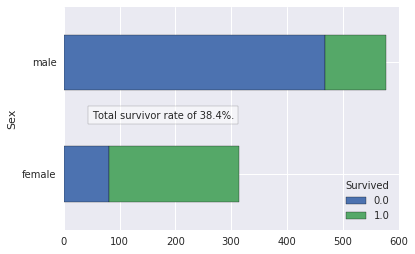

In [4]:
ax = df.groupby(['Sex','Survived']).size().unstack().plot(kind='barh', stacked=True)
surv_rate = sum(df['Survived']==1) / sum(~df['Survived'].isnull())
ax.text(50, 0.5, 'Total survivor rate of %0.1f%%.' % (surv_rate * 100), 
          bbox=dict(facecolor='white', alpha=0.5))

## Age, class and sex distribution
We can then look at the age distribution by sex. The final age bin is opened to avoid having many small bins above an age of 65. We see a similar shaped distribution with more males in groups above age 15. We also see class 1 passengers with a flatter and older distribution.

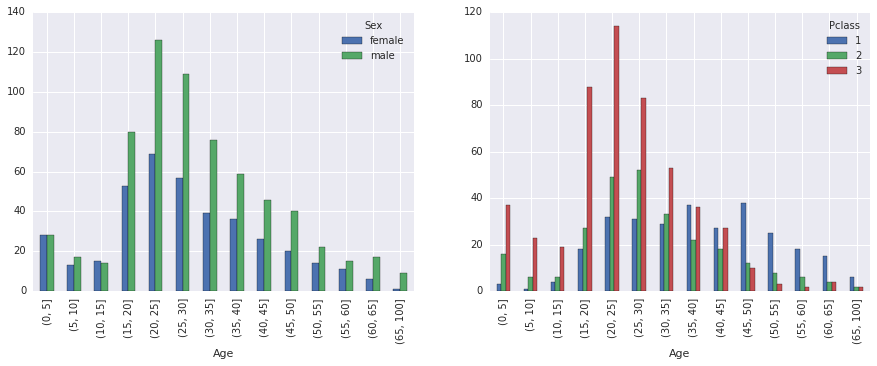

In [5]:
age_binned, age_bins = pd.cut(df['Age'], list(range(0, 66, 5)) + [100], retbins=True)
age_sex_grouped = df.groupby([age_binned, 'Sex'])
age_class_grouped = df.groupby([age_binned, 'Pclass'])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
age_sex_grouped.size().unstack().plot(kind='bar', ax=axs[0])
age_class_grouped.size().unstack().plot(kind='bar', ax=axs[1])

## Age and class survival rate
We can then look at the survival breakdown for the same age categories and class. In general, we see that younger and first class people were more likely to survive.

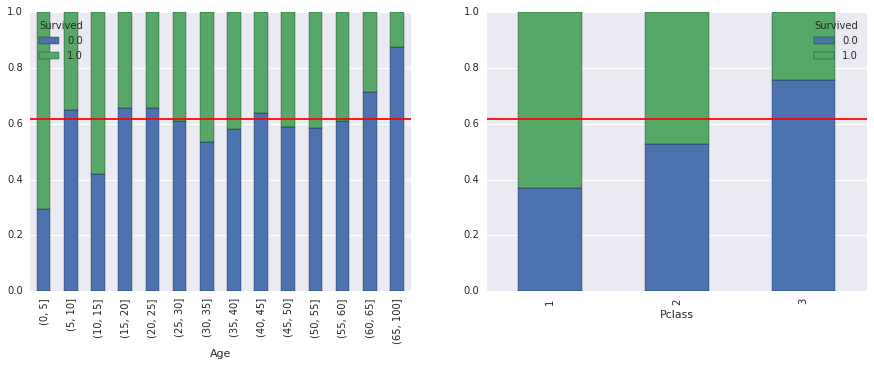

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
def normdf(df):
    return df.div(df.sum(axis=1), axis=0)

age_surv_grouped = df.groupby([age_binned, 'Survived'])
age_surv = age_surv_grouped.size().unstack()
normdf(age_surv).plot(kind='bar', stacked=True, ax=axs[0])

class_surv_grouped = df.groupby(['Pclass', 'Survived'])
class_surv = class_surv_grouped.size().unstack()
normdf(class_surv).plot(kind='bar', stacked=True, ax=axs[1])

for ax in axs: ax.plot(ax.get_xlim(), np.ones(2) * (1-surv_rate), 'r')

# Fare distribution
Fare prices form a sharply decaying distribution with some fares actually at zero dollars.

Free fares: 17


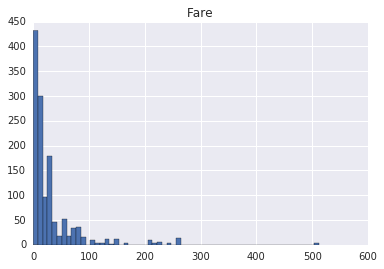

In [7]:
df.hist(column='Fare', bins=60)
print('Free fares: %s' % sum(df['Fare'] == 0.0))

## Low class male population
The sex distribution for 1st and 2nd class roughly follows the sex split, while in 3rd class there is a much larger male population.

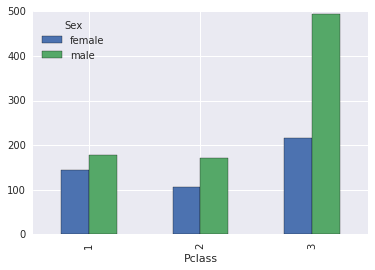

In [8]:
df.groupby(['Pclass', 'Sex']).size().unstack().plot.bar()

We will add a column for the total number of family members by combining SibSp and Parch. This well help to simplify our model and seems like a reasonable approximation that all family members would have equal pull on individuals. The previous male population also seems to stick out with zero family members on board.

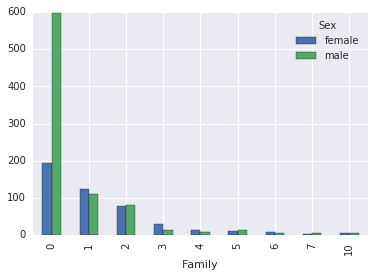

In [9]:
df['Family'] = df['SibSp'] + df['Parch']

df.groupby(['Family', 'Sex']).size().unstack().plot(kind='bar')

We can confirm that this are the same males in 3rd class with no family members on board. This might have been people travelling overseas in search of work.

In [10]:
low_class_no_fam_males = (df['Sex'] == 'male') & (df['Family'] == 0) & (~df['Survived'].isnull())
print('%s low class males with no family and an average fare of $%0.2f.' % 
      (sum(low_class_no_fam_males), df[low_class_no_fam_males]['Fare'].mean()))
print('%0.1f%% of this population survived.' % 
      (100 * sum(df[low_class_no_fam_males]['Survived'] == 1) / sum(low_class_no_fam_males)))

411 low class males with no family and an average fare of $16.71.
15.6% of this population survived.


# Filling missing data
To prepare our dataset for machine learning techniques, we need to deal with missing values. First, let's look at the number of null entries per column. 

In [11]:
df.isnull().sum()

Age          263
Cabin       1014
Embarked       2
Fare           1
Name           0
Parch          0
Pclass         0
Sex            0
SibSp          0
Survived     418
Ticket         0
Family         0
dtype: int64

We will start by filling the single missing fare value with the DataFrame median since this field is very asymetric.

In [12]:
df['Fare'].fillna(df['Fare'].median(), inplace=True)

As we saw above, the age distribution has a long tail and is significantly different by sex and class. We will use a group median to fill missing data with sex and class groups.

We can also see that the survival rate of the group with missing age values is ~10% lower then the total survivor rate. This group tends to be in 3rd class and male. In developing on this dataset, mishandling this population was significantly affecting my models accuracy. We will make a new column for the age filled data. It seems that it is not random which records did not include age information, this may be useful information.

In [13]:
df[df['Age'].isnull()][['Survived', 'Pclass']].describe()

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Survived,Pclass
count,177.000000,263.000000
mean,0.293785,2.642586
std,0.456787,0.726812
min,0.000000,1.000000
25%,NaN,3.000000
50%,NaN,3.000000
75%,NaN,3.000000
max,1.000000,3.000000


In [14]:
class_sex_grouped = df.groupby(['Pclass', 'Sex'])
class_sex_grouped['Age'].median()

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64

We can see that it mostly added values at age 25, which is the 3rd class male population that most of our missing values fell in.

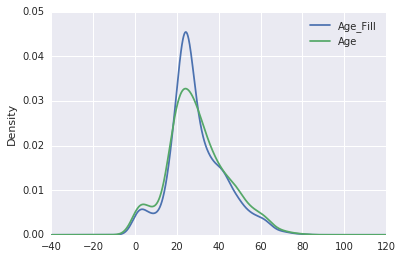

In [15]:
df['Age_Fill'] = df['Age']
df['Age_Missing'] = df['Age'].isnull()
df['Age_Fill'] = class_sex_grouped['Age'].apply(lambda df: df.fillna(df.median()))
df[['Age_Fill', 'Age']].plot(kind='kde')

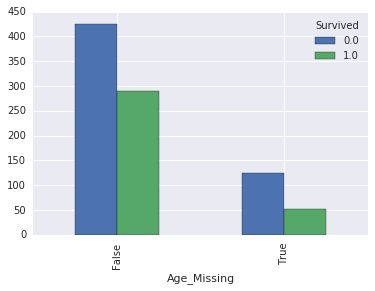

In [16]:
df.groupby(['Age_Missing', 'Survived']).size().unstack().plot(kind='bar')

## Extracting deck information
The cabin field is given in an alphanumeric code for the deck and floor. For instance, 'B23' is floor/deck 'B' and room '23'. We will extract the deck information and it seems likely that people on lower decks had a lower survival rate. There are a significant number of missing values in this field that we need to watch out for. For entries with multiple cabins, we will take the first cabin.

In [17]:
df['Deck'] = df['Cabin'].apply(lambda s: None if str(s) == 'nan' else set([x[0] for x in s.split()]).pop())
df['Deck'].value_counts()

C    94
B    65
D    46
E    44
A    22
F    14
G     9
T     1
Name: Deck, dtype: int64

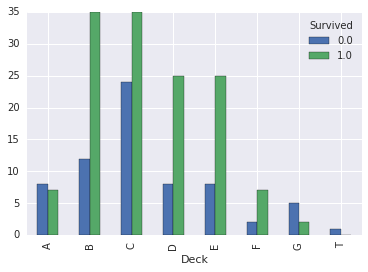

In [18]:
df.groupby(['Deck', 'Survived']).size().unstack().plot.bar()

## Survival Visualizations
Let's now try and visualize survival trends in our data. Since we have many categorical fields in our data, it is hard to find groups visually.

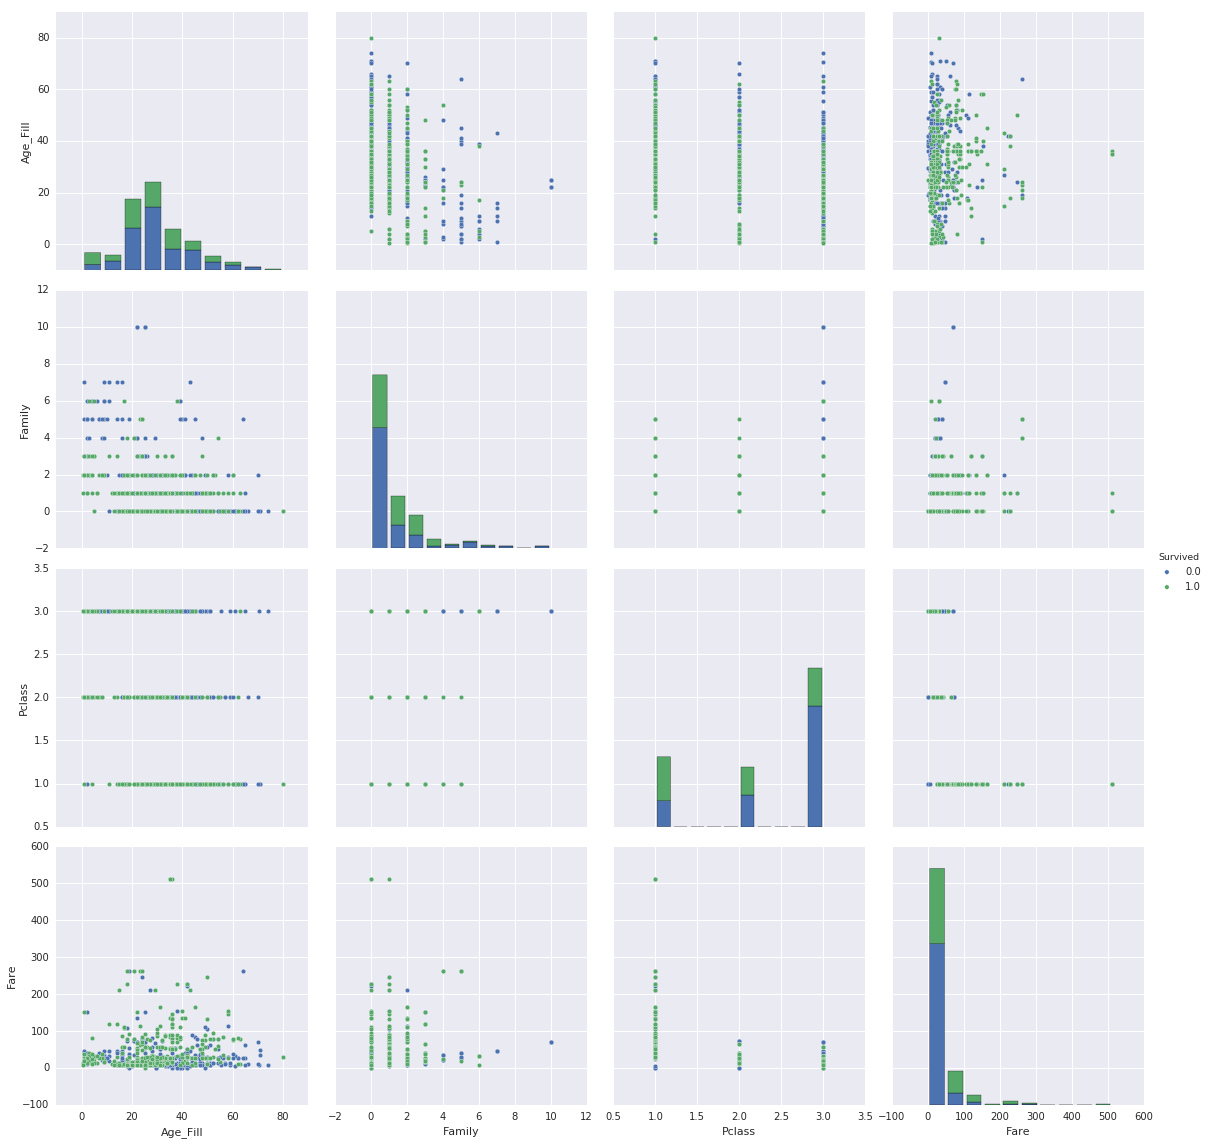

In [19]:
sns.pairplot(df, vars=['Age_Fill', 'Family', 'Pclass', 'Fare'], hue='Survived', size=4)

## Simple Models
Using the hypothesis that women, children, and upper class passengers were more likely to survive, we will build a category based model. We will break down the dataset into sex, class, and adult/children and calculate the survival rate within each group. If the survival rate is over 50% then our model will predict all passengers in that group to have survived. Similarily, if less then 50% survived it will predict that all passengers in that group perished. We will use this model as a benchmark when developing more sophisticated models.

In [20]:
def survivedPerc(df):
    return sum(df['Survived']) / len(df['Survived']) * 100
df[~df['Survived'].isnull()].groupby(['Sex', 'Pclass', df['Age_Fill'] < 16]).apply(survivedPerc).unstack()

Age_Fill           False       True 
Sex    Pclass                       
female 1       97.802198   66.666667
       2       90.909091  100.000000
       3       49.122807   53.333333
male   1       35.294118  100.000000
       2        8.080808  100.000000
       3       11.912226   32.142857

In [21]:
def categoricalClassifier(df):
    num_surv = sum(df['Survived'])
    total = len(df['Survived'])
    correct = num_surv if (num_surv / total) > 0.5 else total - num_surv
    return Series({'Correct' : correct, 'Incorrect' : total - correct})
    
cat_est = df[~df['Survived'].isnull()].groupby(['Sex', 'Pclass', df['Age_Fill'] < 16]).apply(categoricalClassifier)
print('Accuracy: %0.1f' % (cat_est['Correct'].sum() / cat_est.stack().sum() * 100))

df_cat = df.copy()
cat_clf = df_cat.groupby(['Sex', 'Pclass', df_cat['Age_Fill'] < 16])
df_cat['Survived'] = cat_clf['Survived'].apply(lambda df: df.fillna(round(df.mean())))

final['Survived'] = df_cat.ix[final.index]['Survived']
final.to_csv('Data/Titanic_Category_Predictions.csv', columns=['Survived'], float_format='%d')

Accuracy: 80.2


## Model Training

We now do our final preparation before training models. We slice our DataFrame to only look at our columns of interest and add dummy columns for our categorical data. A copy of the DataFrame was used when slicing X and X_final to avoid chained indexing and SettingWithCopyWarnings from Pandas later on.

In [22]:
ml_cols = ['Pclass', 'Fare', 'Family', 'Sex', 'Age_Fill', 'Age_Missing', 'Deck', 'Embarked']
y = df.ix[~df['Survived'].isnull(), 'Survived']
df_ml = df[ml_cols]
df_ml = pd.get_dummies(df_ml, columns=['Deck', 'Embarked'], drop_first=False)
df_ml = pd.get_dummies(df_ml, columns=['Sex'], drop_first=True)
X = df_ml[~df['Survived'].isnull()].copy()
X_final = df_ml[df['Survived'].isnull()].copy()
df_ml.columns.values

array(['Pclass', 'Fare', 'Family', 'Age_Fill', 'Age_Missing', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Deck_T', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_male'], dtype=object)

We then normalize all of the noncategorical columns

In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
std_cols = ['Age_Fill', 'Fare', 'Family']
sc.fit(X[std_cols])

X[std_cols] = sc.transform(X[std_cols])
X_final[std_cols] = sc.transform(X_final[std_cols])
X.head()

,Pclass,Fare,Family,Age_Fill,Age_Missing,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Embarked_C,Embarked_Q,Embarked_S,Sex_male
PassengerId,,,,,,,,,,,,,,,,,
1,3,-0.502445,0.059160,-0.539232,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1,0.786845,0.059160,0.661032,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,-0.488854,-0.560975,-0.239166,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0.420730,0.059160,0.435982,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,3,-0.486337,-0.560975,0.435982,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


We are now ready to test different models on our dataset. A function was built to test classifier accuracy and due some simple hyperparameter tuning. The function first splits the data into an 80% training set and 20% testing set and trains the classifier on this data. A test and training accuracy score are given. Next, parameter tuning is done using 4-fold cross validation. The function accepts a parameter name to alter and an optional range to vary it along. 

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import train_test_split

def clfAccuracy(clf, X, y, param_name, param_range=None, xlog=True):
    '''
    Parameters
    ----------
    clf : Classifier object 
        Must implement fit and predict
    
    X : array-like, shape = [n_samples, n_features]
        Matrix of training samples
    
    Y : array-like, shape = [n_samples]
        Vector of target labels
    
    param_name: string 
        Parameter name to vary
    
    param_range: array-like, numbers
        Optional, default: None
        List of values to vary parameter along
    
    x_log: bool
        Optional, default: True
        Flag to display plot with log x scale
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    print('Training Set Accuracy: %.2f\nTest Set Accuracy %.2f' % 
          (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)))
    
    if not param_range: param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    train_scores, test_scores = validation_curve(estimator=clf,
                                                X=X, y=y, param_name=param_name,
                                                param_range=param_range, cv=4)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.5, color='blue')
    plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5,
            label='validation accuracy')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.grid()
    if xlog: plt.xscale('log')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

We will test a logistic regression, a K-nearest neighbors, a random forest and a support vector machine model. We see very similar results across all models.

Training Set Accuracy: 0.82
Test Set Accuracy 0.77


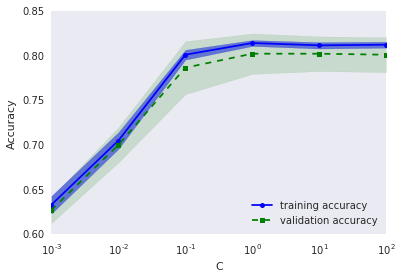

In [25]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000, random_state=0)
clfAccuracy(lr, X, y, 'C')

Training Set Accuracy: 0.85
Test Set Accuracy 0.77


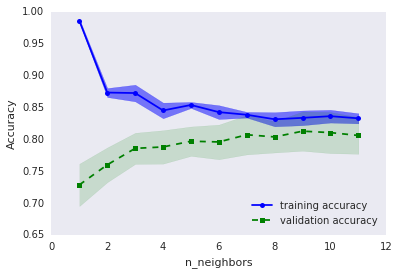

In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=8, p=2, metric='minkowski')
clfAccuracy(knn, X, y, 'n_neighbors', param_range=range(1,12), xlog=False)

Training Set Accuracy: 0.88
Test Set Accuracy 0.77


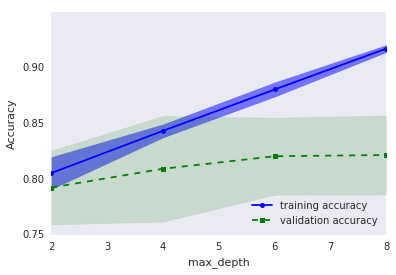

In [27]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini', max_depth=6, n_estimators=100, random_state=1, n_jobs=1)
clfAccuracy(forest, X, y, 'max_depth', param_range=range(2, 10, 2), xlog=False)

Training Set Accuracy: 0.86
Test Set Accuracy 0.78


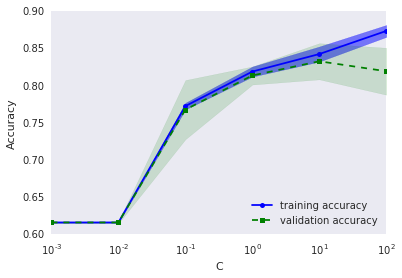

In [28]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=10.0, random_state=1)
clfAccuracy(svm, X, y, 'C')

We can check the misclassified points to see if there is any advantage in building an ensemble classifier. Ideally, each model would need to misclassify different samples for the ensemble to add significant value.

In [29]:
predictions = DataFrame({'lr': lr.predict(X), 'knn': knn.predict(X), 
                         'svm': svm.predict(X), 'forest': forest.predict(X)}, index=X.index)
predictions['sum'] = predictions.sum(axis=1)
print('%s points that the models disagree on of a total %s points.' % 
      (len(predictions[(predictions['sum'] !=4) & (predictions['sum']!=0)]), len(predictions)))

177 points that the models disagree on of a total 891 points.


This number is quite small so we will simply go with our random forest classifier for now.

In [30]:
final['Survived'] = forest.predict(X_final)
final.to_csv('Data/Titanic_Predictions.csv', columns=['Survived'], float_format='%d')